In [1]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [2]:
def split_xy(df):
    return df.iloc[:, :-1], df.iloc[:, -1]

train_df = pd.read_parquet('C:/Users/user/Desktop/bj/Bbeojung.kr/Data/final_dataset/train_1000.parquet')
test_df = pd.read_parquet('C:/Users/user/Desktop/bj/Bbeojung.kr/Data/final_dataset/test_1000.parquet')
x_train, y_train = split_xy(train_df)
x_test, y_test = split_xy(test_df)    

In [3]:
# By compare_model.ipynb
params = {
    'bagging_fraction' : 0.5,
    'bagging_freq' : 0,
    'boosting_type' : 'gbdt',
    'class_weight' : None,
    'colsample_bytree' : 1.0,
    'feature_fraction' : 0.9,
    'importance_type' : 'split',
    'learning_rate' : 0.2,
    'max_depth' : -1,
    'min_child_samples' : 76,
    'min_child_weight' : 0.001,
    'min_split_gain' : 0.5,
    'n_estimators' : 210,
    'n_jobs' : -1,
    'num_leaves' : 150,
    'objective' : None,
    'random_state' : 123,
    'reg_alpha' : 0.005,
    'reg_lambda' : 0.0005,
    'silent' : 'warn',
    'subsample' : 1.0,
    'subsample_for_bin' : 200000,
    'subsample_freq' : 0
}

In [4]:
lgbm = LGBMRegressor(**params)
lgbm.fit(x_train, y_train, eval_metric='mae')
y_pred = lgbm.predict(x_test)

MAE =  mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

print(f'MAE : {MAE}', f'MSE : {MSE}', f'RMSE : {RMSE}', f'R2 : {R2}', sep='\n')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
MAE : 0.8299391040157523
MSE : 2.927623214651599
RMSE : 1.7110298695965536
R2 : 0.9468092789465624


In [12]:
len(lgbm.feature_name_)

72

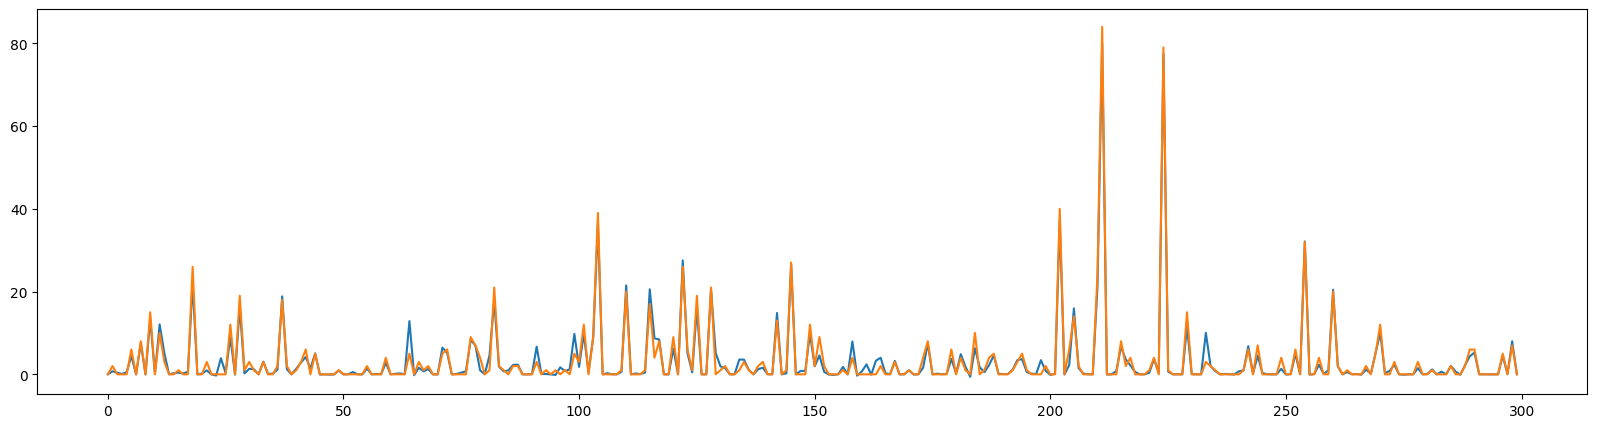

In [14]:
plt.figure(figsize=(20,5))
plt.plot(y_pred.tolist()[2000:2300])
plt.plot(y_test.tolist()[2000:2300])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

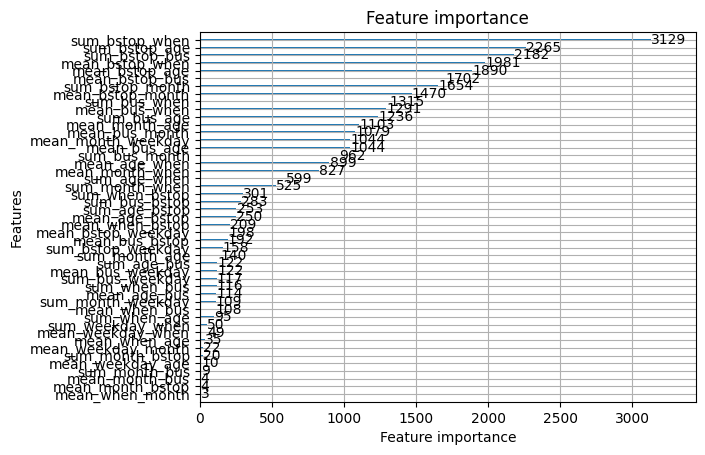

In [15]:
plot_importance(lgbm)

In [16]:
joblib.dump(lgbm, 'C:/Users/user/Desktop/bj/Bbeojung.kr/Web/Model/lgbm_third.pkl')

['C:/Users/user/Desktop/bj/Bbeojung.kr/Web/Model/lgbm_third.pkl']